<a href="https://colab.research.google.com/github/luca02fioravanti/GRAPH-AI/blob/main/ArangoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ArangoML**

Managing machine learning pipelines is challenging as new data arrive and new models are built it is important to have a platform where you can keep track of your `metadata`.

<blockquote>
Metadata describes the components and actions involved in building the machine learning pipeline.
</blockquote>

**Arangopipe** offers a solution to that.


In this notebook we are going to show how machine learning and ArangoDB can work together by creating a knowledge graph and providing missing information using a machine learning model that will be stored with *arangopipe* in ArangoDB.

##**Loading dataset**


We chose a book dataset to show our analysis.

The dataset is available on [Kaggle](https://www.kaggle.com/meetnaren/goodreads-best-books).

In [ ]:
%%capture
!pip install python-arango
!pip install arangopipe==0.0.6.9.3
!pip install pandas PyYAML==5.1.1 sklearn2
!pip install jsonpickle
!pip install langdetect

import pandas as pd

books = pd.read_csv("https://github.com/luca02fioravanti/GRAPH-AI/blob/main/books.csv?raw=true")

The dataset is composed of several columns that describe a book such as: "**book_title**", "**book_desc**", "**genres**".

In [ ]:
books.sample(5)

After loading the dataset we are going to create our **arangopipe** project using its cloud that will give us a temporary database to work with.

In [ ]:
%%capture
from arangopipe.arangopipe_storage.arangopipe_api import ArangoPipe
from arangopipe.arangopipe_storage.arangopipe_admin_api import ArangoPipeAdmin
from arangopipe.arangopipe_storage.arangopipe_config import ArangoPipeConfig
from arangopipe.arangopipe_storage.managed_service_conn_parameters import ManagedServiceConnParam
mdb_config = ArangoPipeConfig()
msc = ManagedServiceConnParam()
conn_params = { msc.DB_SERVICE_HOST : "arangoml.arangodb.cloud", \
                        msc.DB_SERVICE_END_POINT : "createDB",\
                        msc.DB_SERVICE_NAME : "createDB",\
                        msc.DB_SERVICE_PORT : 8529,\
                        msc.DB_CONN_PROTOCOL : 'https'}
        
mdb_config = mdb_config.create_connection_config(conn_params)
admin = ArangoPipeAdmin(reuse_connection = False, config = mdb_config)
ap_config = admin.get_config()
ap = ArangoPipe(config = ap_config)
proj_info = {"name": "Book_Genres_Prediction_Project"}
proj_reg = admin.register_project(proj_info)

We created a project named "Book_Genres_Prediction_Project".

We can access the cloud database by using its credentials that we store on a variable.

In [ ]:
connection = mdb_config.get_cfg()
print("URL: ", "https://arangoml.arangodb.cloud:8529", "\nUsername: ", connection["arangodb"]["username"], "\nPassword: ", connection["arangodb"]["password"])

## **Pre-processing**

Before importing this dataset to ArangoDB we are going to drop those rows that are not useful for our analysis.

The dataset contains `54,301` books written in different languages. 

For the purpose of our computation we are going to drop those books that do not have descriptions as well as those not written in English.

In [ ]:
# Estimated time: ~7m

from langdetect import detect
from tqdm import tqdm
tqdm.pandas()

# This function checks each description to check 
# that is written in English otherwise it removes the row.
def remove_non_english_row(df):
    for i in tqdm(df.index):
        try:
            lang = detect(df.at[i, 'book_desc'])
            if lang != 'en':
                df.drop(index=i, inplace=True)
        except:
            df.drop(index=i, inplace=True)

# Removes rows that have empty descriptions
books.dropna(subset=["book_desc"], inplace=True) 
remove_non_english_row(books)

## **Import on ArangoDB**

So now after preprocessing our dataset we are ready to import it on ArangoDB created by the cloud.

To do so we are going to use `python-arango` APIs.

In [ ]:
from arango import ArangoClient
from arango.http import DefaultHTTPClient
from requests import Session
from typing import MutableMapping, Optional, Tuple, Union
from arango.response import Response
from arango.typings import Headers
from requests.adapters import HTTPAdapter
from requests_toolbelt import MultipartEncoder
from urllib3.util.retry import Retry

def to_dict(df):
    array = []
    for o in df.to_dict('records'):
        temp = {}
        for k, v in o.items():
            if not (v == None or type(v) == float and v != v):
                temp[k] = v
        array.append(temp)
    return array

def clean_db():
  for i in db.collections():
    try:
      db.delete_collection(i["name"])
    except:
      print(i["name"])

class ClientHTTP(DefaultHTTPClient):
    def send_request(
            self,
            session: Session,
            method: str,
            url: str,
            headers: Optional[Headers] = None,
            params: Optional[MutableMapping[str, str]] = None,
            data: Union[str, MultipartEncoder, None] = None,
            auth: Optional[Tuple[str, str]] = None,
    ) -> Response:
        response = session.request(
            method=method,
            url=url,
            params=params,
            data=data,
            headers=headers,
            auth=auth,
            timeout=3600,
        )
        return Response(
            method=method,
            url=response.url,
            headers=response.headers,
            status_code=response.status_code,
            status_text=response.reason,
            raw_body=response.text,
        )


client = ArangoClient(hosts="https://arangoml.arangodb.cloud:8529", http_client=ClientHTTP())
db = client.db(connection["arangodb"]["dbName"], username=connection["arangodb"]["username"], password=connection["arangodb"]["password"])

### **DataFrame import**

This command will:

1.   Create the raw document collection
2.   Import the data on the collection



In [ ]:
raw = db.create_collection("raw")
raw.import_bulk(to_dict(books))

### **Document collections creation**

Before diving into the collections creation we register the dataset metadata that will define some information about it.

In [ ]:
ds_info = {"name" : "books",\
            "description": "This dataset contains rows of books with title, description, genres, ratings and other values",\
           "source": "https://www.kaggle.com/meetnaren/goodreads-best-books" }
ds_reg = ap.register_dataset(ds_info)

In order to create the knowledge graph we are going to split row data into the following document collections:

#### **Book**

In [ ]:
db.create_collection("book")

cursor = db.aql.execute(r"""
for r in raw
    insert {
    "_key": r._key,
    "name": r.book_title,
    "plot": r.book_desc,
    "pages": r.book_pages,
    "isbn": r.book_isbn 
    } into book return NEW""")
# """

while cursor.has_more():
    cursor.fetch()

array = []
for i in cursor.batch():
  array.append(i["_key"])
books["_key"] = array 

#### **Author**

In [ ]:
db.create_collection("author")

db.aql.execute(r"""
let authors = (
    for r in raw
        for i in split(r.book_authors, "|")
            return distinct trim(i)
)
 
for a in authors
    insert {"name": a} into author
""")

#### **Genre**

In [ ]:
db.create_collection("genre")

db.aql.execute(r"""let genres = (
    for r in raw
        for i in split(r.genres, "|")
            return distinct trim(i)
)

for g in genres
    filter g != ''
    insert {"name": g} into genre""")

### **Edge collection creation**

Onced defined the document collections we need an edge collection that stores relations between document collections.

In this example a "conn" edge collection is created and the following relations are added:

In [ ]:
db.create_collection("conn", edge=True)

#### **Author wrote book relation**

In [ ]:
# Estimated time: ~5m

db.aql.execute(r"""
let book_and_author = (for r in raw
    let book_authors = (
        for i in split(r.book_authors, "|")
            return distinct trim(i)
    )
    for a in book_authors
        return {
          "key": r._key,
          "author": a
        }
)

let raw = (for a in book_and_author
    collect autori = a.author into x
    let keys = (
        for i in x
            return i.a.key
    )
    return {
        "author": autori,
        "books": keys
    }
)
    
    
let author = (
    for a in author
        sort a.name
        return a
)
    
for i in 0..length(author)-1
    for book in raw[i].books
        let b = document(concat("book/", book))
        insert {
        "_from": author[i]._id,
        "_to": b._id,
        "label": "wrote"
        } into conn
""")
# """

#### **Book has genre relation**

In [ ]:
# Estimated time: ~10m

db.aql.execute(r"""
let raw = (
    for r in raw
        filter r.genres != null
        let genres = (for i in split(r.genres, "|")
            return distinct trim(i)
        )
        for g in genres
            return {
              "key": r._key,
              "genre": g
            }
)

let pairs = (for r in raw
    collect generi = r.genre into x
    let pair = (
            for i in x
                return i.r.key
        )
    return {
        "genre": generi,
        "books": pair
    }
)
    
let genres = (
    for g in genre
        sort g.name
        return g
)


for i in 0..length(genres)-1
    for j in pairs[i].books
        let b = document(concat("book/", j))
            insert {
            "_to": genres[i]._id,
            "_from": b._id,
            "label": "genre"
            } into conn
""")
# """

### **Graph creation**

After creating our nodes and edges we're going to define the graph.

In [ ]:
graph = db.create_graph("graph")
graph.create_edge_definition(
    edge_collection="conn", 
    from_vertex_collections=["book", "author"], 
    to_vertex_collections=["book", "genre"]
)

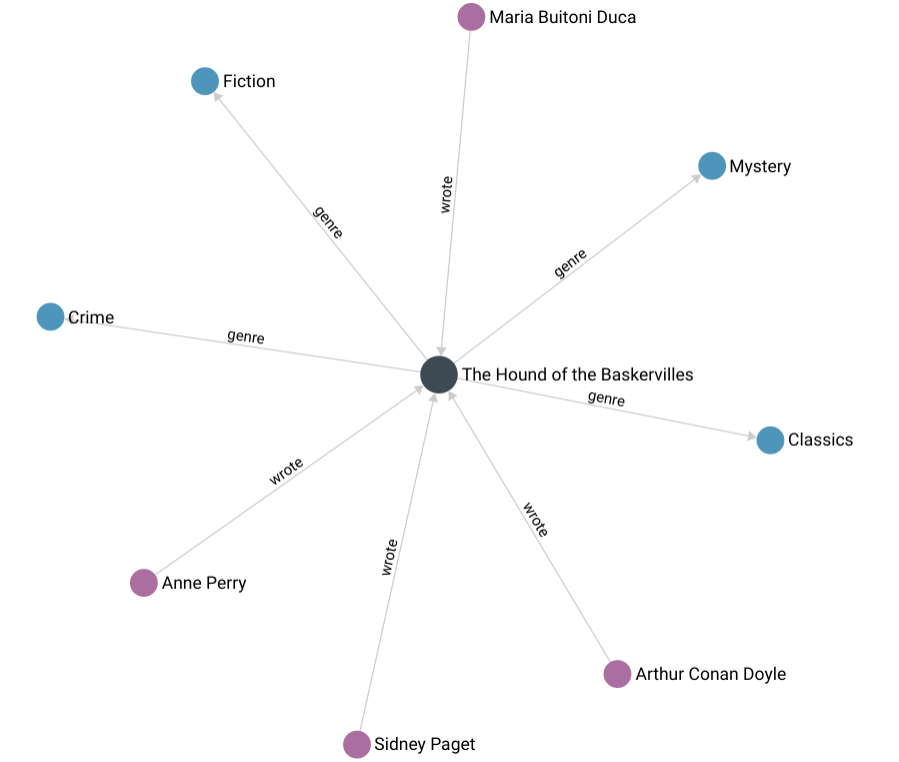

## **Machine Learning**

After creating our knowledge graph we know that not all the books have a genre.

We're going to create a machine learning model that given a book description is able to predict its genre.

### **Cleaning the dataset**

The first thing we are going to do is creating a subset of books containing only those that have genres.

In [ ]:
new_books = books.dropna(subset=["genres"]).copy()

After that we are going to define the function for cleaning book descriptions from:


1.   Whitespaces, apostrophes, numbers, symbols, etc;
2.   Stopwords;



In [ ]:
%%capture
import nltk as nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything except alphabets
    text = re.sub("[^a-zA-Z]", " ", text)
    # remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()
    # removes stopwords
    no_stopwords_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopwords_text)

We're going to create a new column on our dataset that will contain the cleaned descriptions.

In [ ]:
new_books["clean_desc"] = new_books["book_desc"].progress_apply(lambda x: clean_text(x))

Now that we have cleaned our book descriptions we need to rearrange book genres.

The "genres" column, in fact, contains book genres separated by a "|" symbol. 

We are going to create a new column with genres arranged as arrays.

In [ ]:
new_books["genre_new"] = new_books["genres"].progress_apply(lambda x: x.split("|"))

After cleaning our dataset we save with **arangopipe** the set of feauture our model will be working on.

In [ ]:
featureset = new_books[["clean_desc"]].dtypes.to_dict()
featureset = {k:str(featureset[k]) for k in featureset}
featureset["name"] = "array of descriptions"
fs_reg = ap.register_featureset(featureset, ds_reg["_key"])

### **Model definition**

Now its time to define, create and train the model.

In [ ]:
# Estimated time: ~6

%%capture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(new_books['genre_new'])

y = multilabel_binarizer.transform(new_books['genre_new'])
x = new_books['clean_desc']

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.2, random_state=9)
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(xtrain_tfidf, ytrain)
y_pred = clf.predict(xval_tfidf)


Once defined and trained the model with the books, we define the function that given a description is able to predict genres.

In [ ]:
def infer_genres(description):
    description = clean_text(description)
    description_vec = tfidf_vectorizer.transform([description])
    description_pred = clf.predict(description_vec)
    return multilabel_binarizer.inverse_transform(description_pred)

We split from the original dataset those rows that did not have genres and we create another dataset.

After that we iterate over the new dataset and we feed each description to the model that will return a set of predicted genres that we put into the "genres" column.

In [ ]:
# Estimated time: ~3m

missing = books[books.genres.isna()].copy()
missing["genres"] = missing["book_desc"].progress_apply(lambda x: "|".join(infer_genres(x)[0]))

In [ ]:
new = missing.drop(index=missing[missing.genres == ''].index).copy()
new.sample(5)

## **Updating ArangoDB**

Now we're ready to import the new genres to ArangoDB so that we can improve our knowledge graph.

In [ ]:
raw1 = db.create_collection("raw1")
raw1.import_bulk(to_dict(new))

After importing our new dataset, we're going to add new edges to our graph by executing the following query:

In [ ]:
db.aql.execute(r"""
let genres = (
    for j in raw1
        let gx = (for x in split(j.genres, "|")
            return distinct trim(x)
        )
        for g in gx
            return {
              "key": j._key,
              "genre": g
            }
)
 
 
let raw = (
    for g in genres
        collect generi = g.genre into x
        let keys = (
            for i in x
                return i.g.key
        )
        return {
            "genre": generi,
            "books": keys
        }
)
 
for j in genre
    for i in raw
        filter j.name == i.genre
        for x in i.books
            let b = document(concat("book/", x))
            insert {
            "_to": j._id,
            "_from": b._id,
            "label": "genre"
            } into conn
""")
# """

Finally we upload the metadata of our project by adding:


1.   Model name
2.   Model type
3.   Reference to the notebook where we created the model
4.   Model performance



In [ ]:
import io
import requests
url = ('https://raw.githubusercontent.com/luca02fioravanti/GRAPH-AI/main/ArangoML.ipynb')
nbjson = requests.get(url).text

model_info = {"name": "Model to predict genres by plot",  "task": "Regression", 'notebook': nbjson}
model_reg = ap.register_model(model_info, project = proj_info["name"])

In [ ]:
import uuid
import datetime
import jsonpickle

ruuid = str(uuid.uuid4().int)
#
model_perf = {'run_id': ruuid, 'performance': f1_score(yval, y_pred, average="micro"),  "timestamp": str(datetime.datetime.now())}

mp = clf.get_params()
mp = jsonpickle.encode(mp)
model_params = {'run_id': ruuid, 'model_params': mp}

run_info = {"dataset" : ds_reg["_key"],\
                    "featureset": fs_reg["_key"],\
                    "run_id": ruuid,\
                    "model": model_reg["_key"],\
                    "model-params": model_params,\
                    "model-perf": model_perf,\
                    "tag": "Book genre project",\
                    "project": "Book genre project"}
ap.log_run(run_info)


Now if we take a look at the ArangoDB web interface, under the graph tab, we can observe that arangopipe has created a new graph called "**enterprise_ml_graph**" where all the information defined with arangopipe, stored on collections by the system, have been connected in a graph.


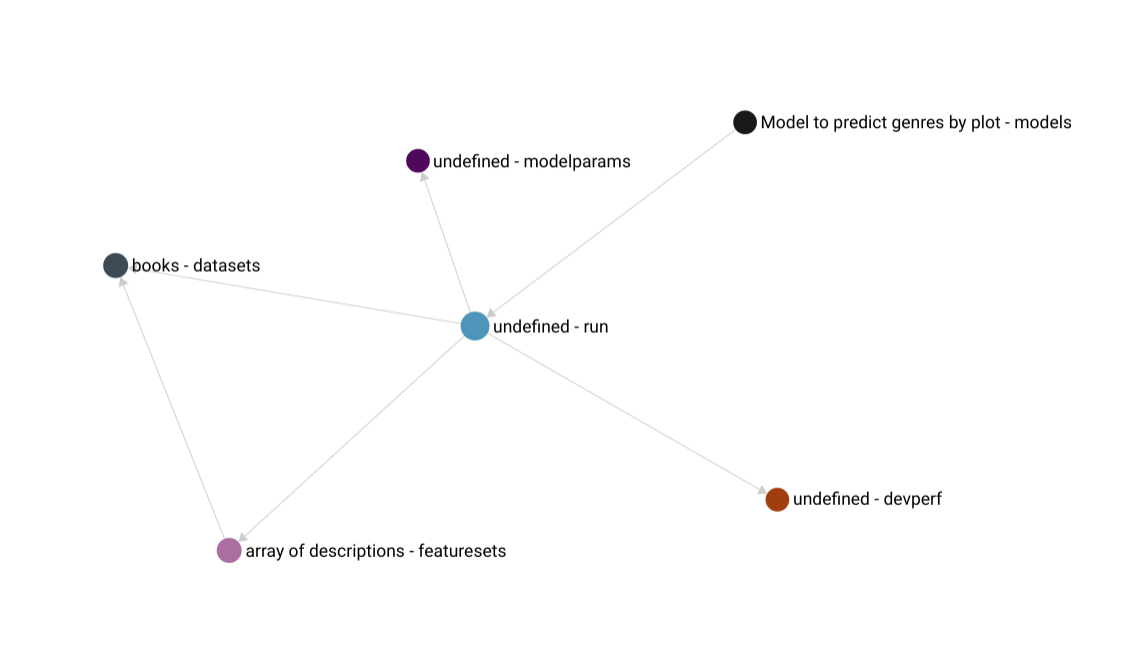

**ArangoPipe** has created 6 collections:

1.   A collection where it stores a description to the dataset and its source.
2.   A collection where it stores the feature set type and its name.
3.   A collection where it stores a description to the model and its code (notebook).
4.   A collection where it stores an instance of the model with its parameters.
5.   And two collection where it stores the performance of the instance of model and the timestamp when it was created.

